In [ ]:
# source: https://github.com/chaithanya21/Sentiment-Analysis-using-Pyspark-on-Multi-Social-Media-Data/blob/master/pyspark_ml_models.ipynb

## Twitter sentiment analysis and prediction using pyspark

In [16]:
!pip install -q pyspark==3.3.0
# spark-nlp==4.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 14.3 MB/s eta 0:00:00


In [17]:
from IPython import display
import math
import pandas as pd
import numpy as np

from pyspark.sql import SQLContext
from pyspark import SparkContext

from pyspark.sql.types import *

### Create Spark Context and load dataset

In [18]:
sc = SparkContext()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [19]:
# MOUNTING GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import os
data_path = "/content/drive/MyDrive/CS 532/cs532_project/data"
df_2005_07_path = os.path.join(data_path, "review_2005-07.csv")

In [21]:
import pandas as pd
data_pd = pd.read_csv(df_2005_07_path, header=0)

df1 = sqlContext.createDataFrame(data_pd)
# df1 = sqlContext.read.format("csv").option("header", "true").load(df_2005_07_path)

df1 = df1.filter((df1.labels_3 == "positive") | (df1.labels_3 == "negative") | (df1.labels_3 == "neutral"))

df1.count()

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


20070

In [22]:
df1.show()

+--------------------+--------+
|                text|labels_3|
+--------------------+--------+
|It's not chicago ...|positive|
|Great service.  T...|positive|
|These guys really...|positive|
|Words cannot desc...|positive|
|Food is decent bu...|negative|
|This place gets a...| neutral|
|Lovely little res...|positive|
|This little hole ...|positive|
|This is the origi...|positive|
|Oh the Sh*tty Kit...|positive|
|Un-safeway.  Meet...|negative|
|i love the breadb...|positive|
|Chefs awesome, se...|positive|
|A hippie coffee s...| neutral|
|Overpriced with s...|negative|
|Rated 5 stars for...|positive|
|Recently changed ...| neutral|
|Food is great (ge...|negative|
|One of the top Me...|positive|
|For Greek food fa...|positive|
+--------------------+--------+
only showing top 20 rows



In [23]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def get_label(label): 
    if label == 'positive': return 1
    elif label == 'negative': return -1
    else: return 0

udf_func = udf(get_label,IntegerType()) #Creating a 'User Defined Function' to calculate distance between two points.
df1 = df1.withColumn("category", udf_func(df1.labels_3)) #Creating column "distance" based on function 'get_distance'
df1.show()

+--------------------+--------+--------+
|                text|labels_3|category|
+--------------------+--------+--------+
|It's not chicago ...|positive|       1|
|Great service.  T...|positive|       1|
|These guys really...|positive|       1|
|Words cannot desc...|positive|       1|
|Food is decent bu...|negative|      -1|
|This place gets a...| neutral|       0|
|Lovely little res...|positive|       1|
|This little hole ...|positive|       1|
|This is the origi...|positive|       1|
|Oh the Sh*tty Kit...|positive|       1|
|Un-safeway.  Meet...|negative|      -1|
|i love the breadb...|positive|       1|
|Chefs awesome, se...|positive|       1|
|A hippie coffee s...| neutral|       0|
|Overpriced with s...|negative|      -1|
|Rated 5 stars for...|positive|       1|
|Recently changed ...| neutral|       0|
|Food is great (ge...|negative|      -1|
|One of the top Me...|positive|       1|
|For Greek food fa...|positive|       1|
+--------------------+--------+--------+
only showing top

In [24]:
df = df1
data = df.na.drop(how='any')
data.show(5)

+--------------------+--------+--------+
|                text|labels_3|category|
+--------------------+--------+--------+
|It's not chicago ...|positive|       1|
|Great service.  T...|positive|       1|
|These guys really...|positive|       1|
|Words cannot desc...|positive|       1|
|Food is decent bu...|negative|      -1|
+--------------------+--------+--------+
only showing top 5 rows



In [25]:
df.count() 

20070

In [26]:
data.printSchema()

root
 |-- text: string (nullable = true)
 |-- labels_3: string (nullable = true)
 |-- category: integer (nullable = true)



## Preprocessing

In [27]:
from pyspark.sql.functions import col

data.groupBy("labels_3").count().orderBy(col("count").desc()).show()
data.groupBy("category").count().orderBy(col("count").desc()).show()

+--------+-----+
|labels_3|count|
+--------+-----+
|positive|14052|
| neutral| 3728|
|negative| 2290|
+--------+-----+

+--------+-----+
|category|count|
+--------+-----+
|       1|14052|
|       0| 3728|
|      -1| 2290|
+--------+-----+



## Model Pipeline
Spark Machine Learning Pipelines API is similar to Scikit-Learn. Our pipeline includes three steps:

regexTokenizer: Tokenization (with Regular Expression)

stopwordsRemover: Remove Stop Words

countVectors: Count vectors (“document-term vectors”)

In [28]:
s = "a about after all also always am an and any are at be been being but by came can cant come \
could did didn't do does doesn't doing don't else for from get give goes going had happen \
has have having how i if ill i'm in into is isn't it its i've just keep let like made make \
many may me mean more most much no not now of only or our really say see some something \
take tell than that the their them then they thing this to try up us use used uses very \
want was way we what when where which who why will with without wont you your you're"
more_stop_words = s.split(' ')

In [29]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# stop words
# add_stopwords = ["http","https","amp","rt","t","c","the"]
add_stopwords = ["http","https","amp","rt","t","c","the"] + more_stop_words


stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=30000, minDF=5)

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(20)

+--------------------+--------+--------+--------------------+--------------------+--------------------+-----+
|                text|labels_3|category|               words|            filtered|            features|label|
+--------------------+--------+--------+--------------------+--------------------+--------------------+-----+
|It's not chicago ...|positive|       1|[it, s, not, chic...|[s, chicago, styl...|(13195,[0,32,51,7...|  0.0|
|Great service.  T...|positive|       1|[great, service, ...|[great, service, ...|(13195,[1,9,23,31...|  0.0|
|These guys really...|positive|       1|[these, guys, rea...|[these, guys, kin...|(13195,[48,66,180...|  0.0|
|Words cannot desc...|positive|       1|[words, cannot, d...|[words, cannot, d...|(13195,[0,1,3,8,9...|  0.0|
|Food is decent bu...|negative|      -1|[food, is, decent...|[food, decent, co...|(13195,[5,7,31,44...|  2.0|
|This place gets a...| neutral|       0|[this, place, get...|[place, gets, 3, ...|(13195,[0,1,3,4,7...|  1.0|
|Lovely li

## Partition Training & Test sets¶

In [31]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 14042
Test Dataset Count: 6028


In [32]:
type(testData)

pyspark.sql.dataframe.DataFrame

## Model Training and Evaluation
Logistic Regression using Count Vector Features 

Our model will make predictions and score on the test set; we then look at the top 10 predictions from the highest probability.

In [33]:
lr = LogisticRegression(maxIter=1000, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0).select("text","category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                          text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|So how do I start to tell y...|       1|[0.9999819554785729,1.24072...|  0.0|       0.0|
|THE FOOD! THE EXPERIENCE!\n...|       1|[0.9999818940859319,5.72374...|  0.0|       0.0|
|I visited the Indiana State...|       1|[0.999980096952317,3.288255...|  0.0|       0.0|
|Dear Mollie,\n\nI love you ...|       1|[0.9999735931268977,7.36601...|  0.0|       0.0|
|Walking tour?! With a guide...|       1|[0.9999332819350316,3.00460...|  0.0|       0.0|
|I'm just really going to ha...|       1|[0.9998313465940412,6.11425...|  0.0|       0.0|
|When I was a child, my fath...|       1|[0.9997810107301484,9.52992...|  0.0|       0.0|
|Not as elegant as some fine...|       1|[0.9997546407404078,2.13474...|  0.0|       0.0|
|There are

In [34]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lrAccuracy = evaluator.evaluate(predictions)
print(lrAccuracy)

0.6815920305559869


### ROC curve

https://spark.apache.org/docs/latest/ml-classification-regression.html#multinomial-logistic-regression

https://spark.apache.org/docs/2.3.0/api/java/org/apache/spark/ml/classification/LogisticRegressionTrainingSummary.html

In [35]:
trainingSummary = lrModel.summary

# for multiclass, we can inspect metrics on a per-label basis
print("\nFalse positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nPrecision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("\nRecall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("\nF-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("\nAccuracy: %s\n\nFPR: %s\n\nTPR: %s\n\nF-measure: %s\n\nPrecision: %s\n\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


False positive rate by label:
label 0: 0.33520994604738447
label 1: 0.00333889816360601
label 2: 0.0001607717041800643

True positive rate by label:
label 0: 0.9995909602208815
label 1: 0.6298384066140549
label 2: 0.700374531835206

Precision by label:
label 0: 0.8724562656194217
label 1: 0.9778296382730455
label 2: 0.998220640569395

Recall by label:
label 0: 0.9995909602208815
label 1: 0.6298384066140549
label 2: 0.700374531835206

F-measure by label:
label 0: 0.9317066196444741
label 1: 0.7661714285714286
label 2: 0.8231841526045488

Accuracy: 0.895385272753169

FPR: 0.2340948886683396

TPR: 0.8953852727531691

F-measure: 0.8879562895174741

Precision: 0.9067728211885109

Recall: 0.8953852727531691


## Logistic Regression using TF-IDF Features¶

In [36]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=30000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
lr = LogisticRegression(maxIter=1000, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                          text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|If anywhere on this good ea...|       1|[0.9999304286992323,1.03087...|  0.0|       0.0|
|Dear Mollie,\n\nI love you ...|       1|[0.9999203539652023,1.33418...|  0.0|       0.0|
|THE FOOD! THE EXPERIENCE!\n...|       1|[0.9999004676689583,3.60636...|  0.0|       0.0|
|Walking tour?! With a guide...|       1|[0.9997486777859416,5.15519...|  0.0|       0.0|
|When I was a child, my fath...|       1|[0.9997237098488343,1.38676...|  0.0|       0.0|
|Having just read about Marc...|       1|[0.9996943709164281,1.49459...|  0.0|       0.0|
|Can't say enough fabulous t...|       1|[0.9995444511877267,8.14861...|  0.0|       0.0|
|I'm just really going to ha...|       1|[0.999352916333634,1.643091...|  0.0|       0.0|
|i have to

In [37]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.6819544058700594

In [ ]:
# SAVE MODEL
# lrModel.save(os.path.join(data_path, "LR_model_2"))

## Cross-Validation
Let’s now try cross-validation to tune our hyper parameters, and we will only tune the count vectors Logistic Regression.

In [38]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

lr = LogisticRegression(maxIter=1000, regParam=0.3, elasticNetParam=0)

In [43]:
testData.show(10)

+--------------------+--------+--------+--------------------+--------------------+--------------------+-----+
|                text|labels_3|category|               words|            filtered|            features|label|
+--------------------+--------+--------+--------------------+--------------------+--------------------+-----+
|"Every time I hav...|positive|       1|[every, time, i, ...|[every, time, gon...|(13195,[2,6,7,11,...|  0.0|
|"Oh have you trie...|negative|      -1|[oh, have, you, t...|[oh, tried, jims,...|(13195,[0,2,6,8,1...|  2.0|
|"Oh, sweet Madele...|positive|       1|[oh, sweet, madel...|[oh, sweet, madel...|(13195,[4,6,14,16...|  0.0|
|"There's Nothing ...|positive|       1|[there, s, nothin...|[there, s, nothin...|(13195,[0,1,2,4,5...|  0.0|
|"This is a great ...|positive|       1|[this, is, a, gre...|[great, place, sp...|(13195,[3,8,9,10,...|  0.0|
|"You're going to ...|negative|      -1|[you, re, going, ...|[re, philadelphia...|(13195,[0,1,2,4,5...|  2.0|
|"are we g

In [44]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)
#print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

0.6947456456510891

## Naive Bayes

In [40]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
nbModel = nb.fit(trainingData)
predictions = nbModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                          text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|A charming BYO with creativ...|       1|[1.0,6.441606333075756E-17,...|  0.0|       0.0|
|If you're looking for uniqu...|       1|[1.0,1.9046210464466437E-18...|  0.0|       0.0|
|Absolutely Fantastic.\n\nNo...|       1|[1.0,4.421137038596867E-19,...|  0.0|       0.0|
|Dear Mollie,\n\nI love you ...|       1|[1.0,1.3694542475292946E-19...|  0.0|       0.0|
|Walking tour?! With a guide...|       1|[1.0,5.981693826964445E-20,...|  0.0|       0.0|
|When I was a child, my fath...|       1|[1.0,4.408276831063535E-20,...|  0.0|       0.0|
|Get to the point: Tradition...|       1|[1.0,1.0555064133516752E-21...|  0.0|       0.0|
|THE FOOD! THE EXPERIENCE!\n...|       1|[1.0,6.16694820449366E-23,2...|  0.0|       0.0|
|Not as el

In [41]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nbAccuracy = evaluator.evaluate(predictions)
print(nbAccuracy)

0.7161274960797515


In [42]:
# SAVE MODEL
nbModel.save(os.path.join(data_path, "NB_model"))

### DecisionTreeClassifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10)
dtModel = dt.fit(trainingData)
predictions = dtModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+-------------+-----+----------+
|                          text|category|  probability|label|prediction|
+------------------------------+--------+-------------+-----+----------+
|Govinda's Cafe (Gourmet to ...|       1|[1.0,0.0,0.0]|  0.0|       0.0|
|An average neighborhood che...|       0|[1.0,0.0,0.0]|  1.0|       0.0|
|"Oh have you tried Jims? Yo...|      -1|[1.0,0.0,0.0]|  2.0|       0.0|
|I love 610 because, while y...|       1|[1.0,0.0,0.0]|  0.0|       0.0|
|I ordered a turkey sandwich...|       0|[1.0,0.0,0.0]|  1.0|       0.0|
|I visited S&W last night du...|       0|[1.0,0.0,0.0]|  1.0|       0.0|
|I've been once, and I was n...|       0|[1.0,0.0,0.0]|  1.0|       0.0|
|If you love quality...\n\nI...|       1|[1.0,0.0,0.0]|  0.0|       0.0|
|Obviously the place is clea...|       1|[1.0,0.0,0.0]|  0.0|       0.0|
|Tasty and cheap average Mex...|       1|[1.0,0.0,0.0]|  0.0|       0.0|
+------------------------------+--------+----------

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
dtAccuracy = evaluator.evaluate(predictions)
print(dtAccuracy) 

0.6237050209452044


## Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 400, \
                            maxDepth = 16, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                          text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|This place is always packed...|       1|[0.8101103285865597,0.13377...|  0.0|       0.0|
|Norma's is absolutely my FA...|       1|[0.8064194921944724,0.13133...|  0.0|       0.0|
|This is definitely one of m...|       1|[0.8055500541869531,0.13107...|  0.0|       0.0|
|I have lived in Reno my ent...|       1|[0.8051380462018564,0.12746...|  0.0|       0.0|
|If you are looking for a go...|       1|[0.7972709175118315,0.13790...|  0.0|       0.0|
|Amazing. Everything we ate ...|       1|[0.7957758220145466,0.13156...|  0.0|       0.0|
|Wonderful neighborhood plac...|       1|[0.793230850396304,0.135083...|  0.0|       0.0|
|I loved NOLA. Such a great ...|       1|[0.7923947587266099,0.13872...|  0.0|       0.0|
|Excellent

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rfAccuracy = evaluator.evaluate(predictions)
print(rfAccuracy) 

0.5880891277394487


## OnevsRest classifer

In [ ]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

lr = LogisticRegression(maxIter=1000, regParam=0.3, elasticNetParam=0)

ovr = OneVsRest(classifier=lr)

ovrModel = ovr.fit(trainingData)

# score the model on test data.
predictions = ovrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("text","category","label","prediction") \
    .show(n = 10, truncate = 30)

+------------------------------+--------+-----+----------+
|                          text|category|label|prediction|
+------------------------------+--------+-----+----------+
|"Every time I have gone par...|       1|  0.0|       0.0|
|"Oh have you tried Jims? Yo...|      -1|  2.0|       0.0|
|"Oh, sweet Madeleine\nGood ...|       1|  0.0|       0.0|
|"There's Nothing Like A Gre...|       1|  0.0|       0.0|
|"This is a great place - if...|       1|  0.0|       0.0|
|"are we going to see a play...|       1|  0.0|       0.0|
|"whadduya want, waht kind o...|       1|  0.0|       0.0|
|$1.50 for polish dog and so...|       1|  0.0|       0.0|
|'Um... with some ranch and ...|       1|  0.0|       0.0|
|'twas good. My favorite typ...|       1|  0.0|       0.0|
+------------------------------+--------+-----+----------+
only showing top 10 rows



In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
ovrAccuracy = evaluator.evaluate(predictions)
print(ovrAccuracy)

0.6631934010728144


## Visualization

In [14]:
import matplotlib.pyplot as plt
import numpy as np

model = ['Logistic regression', 'Naive Bayes', 'Random Forest', 'OneVsRest']
accuracy = [lrAccuracy, nbAccuracy, rfAccuracy, ovrAccuracy]
# accuracy = [0.6815920305559869, 0.7161274960797515, 0.5880891277394487, 0.6631934010728144]

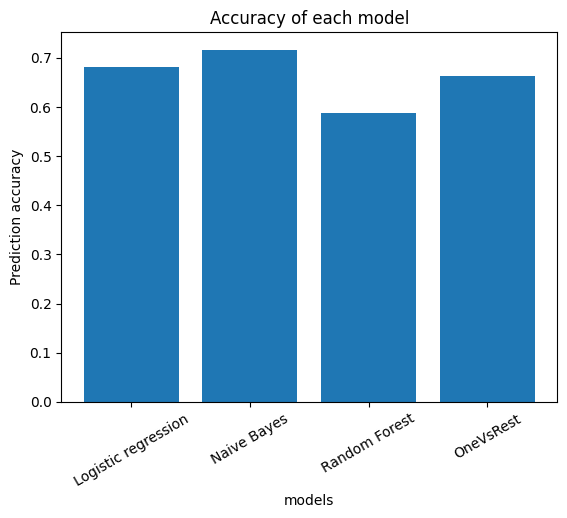

In [15]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy)
    plt.xlabel('models', fontsize=10)
    plt.ylabel('Prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()
    
plot_bar_x()

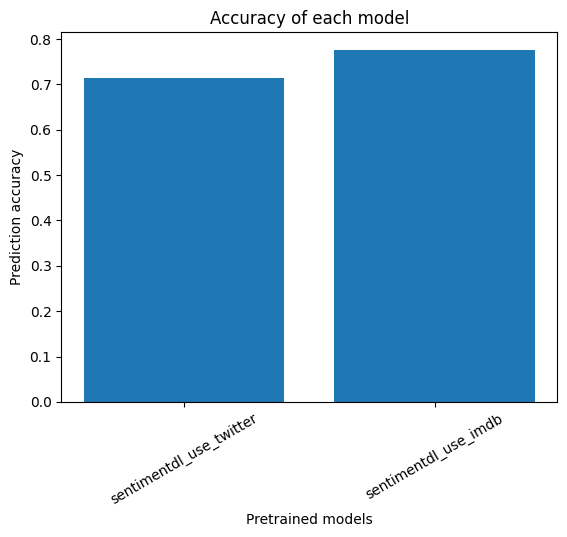

In [13]:
import matplotlib.pyplot as plt
import numpy as np

model = ['sentimentdl_use_twitter', 'sentimentdl_use_imdb']
accuracy = [0.7140733378040285, 0.7759489577717824]

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy)
    plt.xlabel('Pretrained models', fontsize=10)
    plt.ylabel('Prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()
    
plot_bar_x()